In [93]:
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import scipy.stats

In [2]:
nDf = 21

In [3]:
def read_dataset(n):
    n += 1
    strN = str(n)
    if n < 10:
        strN = '0' + strN
    train_df = pd.read_csv("../input/DT/" + strN + "_train.csv")
    test_df = pd.read_csv("../input/DT/" + strN + "_test.csv")
    return (train_df.drop('y', axis=1), train_df['y'],
            test_df.drop('y', axis=1), test_df['y'])

In [129]:
def find_optimal_height(df_index, height_grid, return_acc=False):
    X_train, y_train, X_test, y_test = read_dataset(df_index)
    best_params = dict.fromkeys(['max_depth', 'criterion', 'splitter'])
    best_accuracy = 0.
    train_progress, test_progress = [], []
    for height in height_grid:
        print('learning with max_depth={}'.format(height))
        for criterion in ['gini', 'entropy']:
            for splitter in ['best', 'random']:
                clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=height)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                if return_acc:
                    if len(test_progress) > 0 and test_progress[-1][0] == height:
                        test_progress[-1] = test_progress[-1] if test_progress[-1][1] >= acc else (height, acc)
                    else:
                        test_progress.append((height, acc))
                    train_acc = accuracy_score(y_train, clf.predict(X_train))
                    if len(train_progress) > 0 and train_progress[-1][0] == height:
                        train_progress[-1] = train_progress[-1] if train_progress[-1][1] >= acc else (height, train_acc)
                    else:
                        train_progress.append((height, train_acc))
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_params['max_depth'] = height
                    best_params['criterion'] = criterion
                    best_params['splitter'] = splitter
                    print('found new best accuracy={} \nhyper params={}'.format(best_accuracy, best_params))
        print('-----------------')
    if return_acc:
        return best_accuracy, best_params, train_progress, test_progress
    return best_accuracy, best_params

In [5]:
min_optimal = (0, 10000)
max_optimal = (0, 0)
for df_index in range(nDf):
    heights = [i for i in range(1, 31)]
    print('dataset index={}'.format(df_index))
    accuracy, hParams = find_optimal_height(df_index, heights)
    if hParams['max_depth'] < min_optimal[1]:
        min_optimal = (df_index, hParams['max_depth'])
    if hParams['max_depth'] > max_optimal[1]:
        max_optimal = (df_index, hParams['max_depth'])
    print('min_optimal={}'.format(min_optimal))
    print('max_optimal={}'.format(max_optimal))    
    print()

dataset index=0
learning with max_depth=1
found new best accuracy=0.638396299151889 
hyper params={'max_depth': 1, 'criterion': 'gini', 'splitter': 'best'}
-----------------
learning with max_depth=2
found new best accuracy=0.8650732459521974 
hyper params={'max_depth': 2, 'criterion': 'gini', 'splitter': 'best'}
-----------------
learning with max_depth=3
found new best accuracy=0.9994859933179131 
hyper params={'max_depth': 3, 'criterion': 'gini', 'splitter': 'best'}
found new best accuracy=0.9997429966589566 
hyper params={'max_depth': 3, 'criterion': 'entropy', 'splitter': 'best'}
-----------------
learning with max_depth=4
-----------------
learning with max_depth=5
-----------------
learning with max_depth=6
-----------------
learning with max_depth=7
-----------------
learning with max_depth=8
-----------------
learning with max_depth=9
-----------------
learning with max_depth=10
-----------------
learning with max_depth=11
-----------------
learning with max_depth=12
---------

In [7]:
print('min height={} on dataset #{}'.format(min_optimal[1], min_optimal[0] + 1))
print('max height={} on dataset #{}'.format(max_optimal[1], max_optimal[0] + 1))

min height=1 on dataset #3
max height=10 on dataset #12


In [130]:
_, _, heights_train_acc1, heights_test_acc1 = find_optimal_height(min_optimal[0], [i for i in range(1, 51)], return_acc=True)
_, _, heights_train_acc2, heights_test_acc2 = find_optimal_height(max_optimal[0], [i for i in range(1, 51)], return_acc=True)

learning with max_depth=1
found new best accuracy=1.0 
hyper params={'max_depth': 1, 'criterion': 'gini', 'splitter': 'best'}
-----------------
learning with max_depth=2
-----------------
learning with max_depth=3
-----------------
learning with max_depth=4
-----------------
learning with max_depth=5
-----------------
learning with max_depth=6
-----------------
learning with max_depth=7
-----------------
learning with max_depth=8
-----------------
learning with max_depth=9
-----------------
learning with max_depth=10
-----------------
learning with max_depth=11
-----------------
learning with max_depth=12
-----------------
learning with max_depth=13
-----------------
learning with max_depth=14
-----------------
learning with max_depth=15
-----------------
learning with max_depth=16
-----------------
learning with max_depth=17
-----------------
learning with max_depth=18
-----------------
learning with max_depth=19
-----------------
learning with max_depth=20
-----------------
learning 

In [142]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

plot_df1 = pd.concat([pd.DataFrame(heights_train_acc1, columns=['height', 'accuracy']).assign(dataset='train'), 
           pd.DataFrame(heights_test_acc1, columns=['height', 'accuracy']).assign(dataset='test')])
plot_df2 = pd.concat([pd.DataFrame(heights_train_acc2, columns=['height', 'accuracy']).assign(dataset='train'), 
           pd.DataFrame(heights_test_acc2, columns=['height', 'accuracy']).assign(dataset='test')])

[Text(0.5, 1.0, 'Min. optimal height dataset#3')]

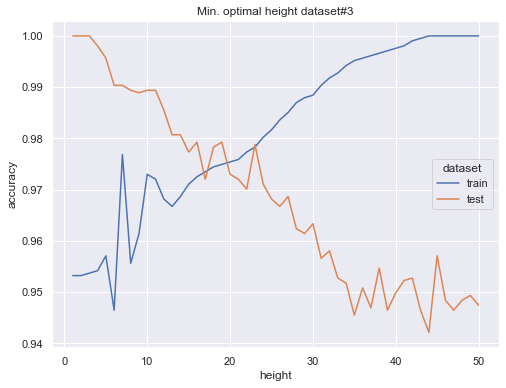

In [147]:
plt.figure(figsize=(8,6))
sns.lineplot(x="height", y="accuracy", data=plot_df1, hue='dataset').set(
    title='Min. optimal height dataset#{}'.format(min_optimal[0] + 1))

[Text(0.5, 1.0, 'Max. optimal height dataset#12')]

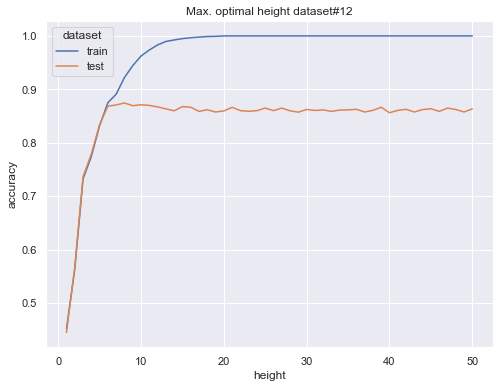

In [149]:
plt.figure(figsize=(8,6))
sns.lineplot(x="height", y="accuracy", data=plot_df2, hue='dataset').set(
    title='Max. optimal height dataset#{}'.format(max_optimal[0] + 1))

In [136]:
def predict_with_forest(forest, X):
    predicted_labels = []
    for clf in forest:
        predicted_labels.append(clf.predict(X))
    predicted_labels = scipy.stats.mode(np.stack(predicted_labels))[0][0]
    return predicted_labels


def classify_with_random_forest(df_index, forest_size=1000):
    X_train, y_train, X_test, y_test = read_dataset(df_index)
    forest = []
    train_df = X_train.copy()
    train_df['y'] = y_train
    for i in range(forest_size):
        clf = DecisionTreeClassifier(criterion='entropy', max_features="sqrt")
        train_random = train_df.sample(len(train_df.index), replace=True)
        # print('Fitting tree#{}'.format(i + 1))
        clf.fit(train_random.drop('y', axis=1), train_random['y'])
        forest.append(clf)
    y_train_pred = predict_with_forest(forest, X_train)
    y_test_pred = predict_with_forest(forest, X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print('Acuuracy on train: {:.5f}'.format(train_accuracy))
    print('Acuuracy on test: {:.5f}'.format(test_accuracy))
    return forest, train_accuracy, test_accuracy

In [151]:
for df_index in range(nDf):
    print('Running random forest on dataset #{}'.format(df_index + 1))
    classify_with_random_forest(df_index, forest_size=1)
    print('--------------------------------------')

Running random forest on dataset #1
Acuuracy on train: 0.95117
Acuuracy on test: 0.90285
--------------------------------------
Running random forest on dataset #2
Acuuracy on train: 0.69517
Acuuracy on test: 0.18473
--------------------------------------
Running random forest on dataset #3
Acuuracy on train: 0.96191
Acuuracy on test: 0.93925
--------------------------------------
Running random forest on dataset #4
Acuuracy on train: 0.83930
Acuuracy on test: 0.59304
--------------------------------------
Running random forest on dataset #5
Acuuracy on train: 0.97619
Acuuracy on test: 0.95022
--------------------------------------
Running random forest on dataset #6
Acuuracy on train: 0.88300
Acuuracy on test: 0.68929
--------------------------------------
Running random forest on dataset #7
Acuuracy on train: 0.86698
Acuuracy on test: 0.62930
--------------------------------------
Running random forest on dataset #8
Acuuracy on train: 0.98337
Acuuracy on test: 0.92723
---------------